# K-Means Clustering and Multiple Correspondence Analysis

This notebook applies K-Means Clustering and Multiple Correspondence Analysis algorithms on a dataset that describes a group of people (based on some of their categorical and numeric characteristics) to find out which categories of the different variables are most closely associated with each other. The first step is to apply the K-Means Clustering Method (which only considers numerical parameters) in order to group people into clusters, according to their similarity. Later, the cluster variable will serve as a parameter for the Multiple Correspondence Analysis (with the rest of the categorical variables) to find the strongest associations between the characteristics and the final output is a Perceptual Map representing how close the categories are to each other.


### Methods Description

- **K-Means Clustering** is a method used to group objects in clusters based on their similarity. Steps:

     - Normalize the numeric variables;
     
     - Find out the ideal number of Clusters using the Elbow Method;
     
     - Check the results.
    


- **Multiple Correspondence Analysis (MCA)** is a data analysis technique for nominal categorical data that allows finding the association between two or more qualitative variables. Steps:

     - Check the correspondence between variables (variables with no significant correspondence wouldn't be used);
     
     - Calculate the number of dimentions;
     
     - Plot the Perceptual Map.

In [224]:
# Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import prince

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")
sns.set()

## First look at the dataset

In [225]:
# Getting Data
df_people = pd.read_csv(r'Data/people.csv', index_col=0)
df_people.head(5)

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size
1,Male,No,22,No,Low,4
2,Female,Yes,38,Yes,Average,3
3,Female,Yes,67,Yes,Low,1
4,Male,Yes,67,Yes,High,2
5,Female,Yes,40,Yes,High,6


In [226]:
# Descriptive Statistics of numeric variables
df_people.describe()

,Age,Family_Size
count,7538.000000,7538.000000
mean,43.524144,2.845450
std,16.612202,1.527899
min,18.000000,1.000000
25%,31.000000,2.000000
50%,41.000000,3.000000
75%,53.000000,4.000000
max,89.000000,9.000000


In [227]:
# Separating Categorical and Numeric variables
df_people_num = df_people[['Age','Family_Size']]
df_people = df_people.drop(['Age', 'Family_Size'], 1)

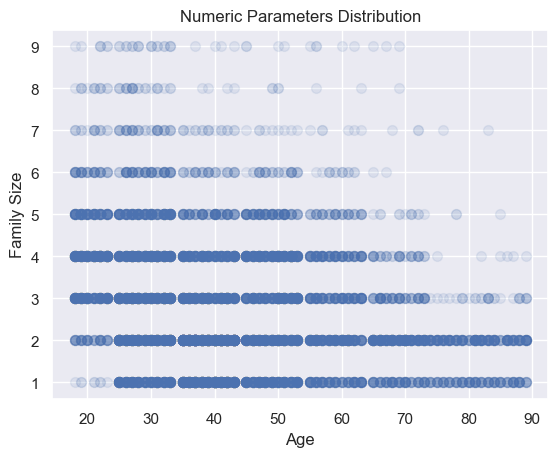

In [228]:
# Ploting the Numeric Values
plt.scatter(df_people_num['Age'], df_people_num['Family_Size'], alpha=.1, s=50)
plt.title('Numeric Parameters Distribution')
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.show()

In [229]:
# Normalizing numeric variables
scaler = StandardScaler()
df_people_num_normalized = scaler.fit_transform(df_people_num)

## K-means Clustering

In order to define the number of cluster the WCSS method (which is defined by the sum of the squared distance between each member of the cluster and its centroid) will be used.

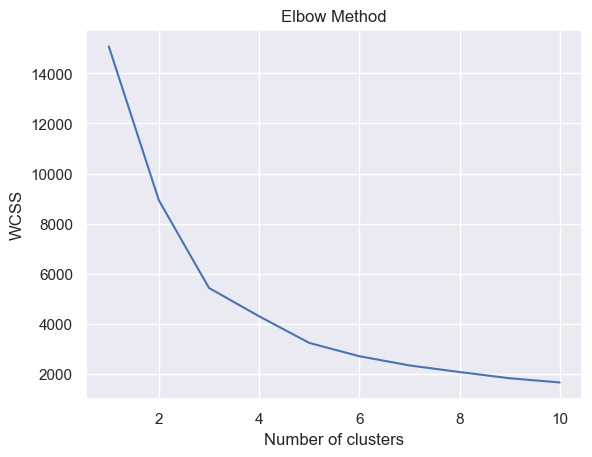

In [230]:
# Plotting the Elbow Method Graph
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_people_num_normalized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It can be seen from the graph that 5 is the ideal number of clusters, as the WCSS value has a small decrease towards the next value.

In [231]:
# Applying Kmeans 5 clusters
kmeans = KMeans(n_clusters=5, algorithm ='auto', init='random')
labels = kmeans.fit_predict(df_people_num_normalized)

In [251]:
# Checking clusters mean values
df_clusters = pd.DataFrame(index = [0, 1, 2, 3, 4], columns=['Age', 'Family_Size'])
df_clusters['Age'] = df_people_num.groupby('c')['Age'].agg('mean')
df_clusters['Family_Size'] = df_people_num.groupby('c')['Family_Size'].agg('mean')
df_clusters

,Age,Family_Size
0,70.269115,1.802849
1,30.911765,5.870844
2,51.702177,3.786936
3,28.735079,3.425091
4,38.693264,1.587410


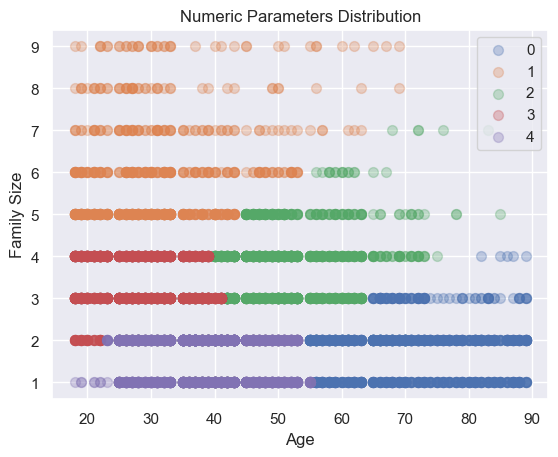

In [232]:
# Ploting the Numeric Values grouped by the clusters
df_people_num['c'] = labels
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==0], df_people_num['Family_Size'].loc[df_people_num['c']==0], alpha=.3, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==1], df_people_num['Family_Size'].loc[df_people_num['c']==1], alpha=.3, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==2], df_people_num['Family_Size'].loc[df_people_num['c']==2], alpha=.3, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==3], df_people_num['Family_Size'].loc[df_people_num['c']==3], alpha=.3, s=50)
plt.scatter(df_people_num['Age'].loc[df_people_num['c']==4], df_people_num['Family_Size'].loc[df_people_num['c']==4], alpha=.3, s=50)
plt.title('Numeric Parameters Distribution')
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.legend(['0', '1', '2', '3', '4'])
plt.show()

In [233]:
# Adding the cluster to the categorical dataframe
df_people['Cluster'] = labels.astype(str)
df_people.head(5)

,Gender,Ever_Married,Graduated,Spending_Score,Cluster
1,Male,No,No,Low,3
2,Female,Yes,Yes,Average,3
3,Female,Yes,Yes,Low,0
4,Male,Yes,Yes,High,0
5,Female,Yes,Yes,High,1


In [234]:
# Summarizing 
for col in df_people.columns:
    print(col)
    print(f'{df_people[col].value_counts()}\n')

Gender
Male      4163
Female    3375
Name: Gender, dtype: int64

Ever_Married
Yes    4466
No     3072
Name: Ever_Married, dtype: int64

Graduated
Yes    4731
No     2807
Name: Graduated, dtype: int64

Spending_Score
Low        4504
Average    1888
High       1146
Name: Spending_Score, dtype: int64

Cluster
4    2494
3    1642
0    1334
2    1286
1     782
Name: Cluster, dtype: int64



All the dataframe parameters are categorical (even the cluster's column being 0, 1, ... they're categorical, could be replaced for 'A', 'B', ...).

## Multiple Correspondence Analysis

Multiple Match Analysis is based on the correspondence between columns. If there is a column with no significant correspondence to any other column it can be removed, the test uses the chi-square contingency value.

If the minimum match of a column to another column is less than 0.05, the column is retained, otherwise it will be dropped.

In [235]:
# Testing the correspondence between columns
assosc_table = pd.DataFrame(index=df_people.columns, columns=df_people.columns)
for idx in assosc_table.index:
    for col in assosc_table.columns:
        if col != idx:
            contingency = df_people[[col, idx]].value_counts().reset_index().pivot(index=[col], columns=[idx])[0].fillna(0)
            assosc_table[col].loc[idx] = scipy.stats.chi2_contingency(contingency)[1]
assosc_table.min()

Gender            0.0
Ever_Married      0.0
Graduated         0.0
Spending_Score    0.0
Cluster           0.0
dtype: object

The MCA's outputs are a group of coordinates for each category of each parameter. The cordinates have *n* dimensions, where:

n = total categories - total variables

In [236]:
# Number of dimensions
total_dimensions = 0
for column in df_people.columns:   
    total_dimensions += len(df_people[column].value_counts())
total_dimensions = total_dimensions - len(df_people.columns)

In [237]:
# Applying MCA for the dataset considering the all the possible dimensions
mca = prince.MCA(n_components = total_dimensions)
mca = mca.fit(df_people)

In [238]:
# Variance of each dimension
mca.explained_inertia_

[0.24521730500857733,
 0.1500101688797174,
 0.1320196726889288,
 0.11248682262418994,
 0.10344561841386743,
 0.08807443286493241,
 0.07627068021671964,
 0.062259618564934616,
 0.030215680738131814]

The sum of all the dimensions inertia represents 100% of the total variance.

In order to plot the Perceptual Map, the 2 most relevant dimentions will be used, which helds 40% of the total variance.

In [239]:
# Applying MCA for the dataset for 2 dimensions
mca = prince.MCA(n_components = 2)
mca = mca.fit(df_people)

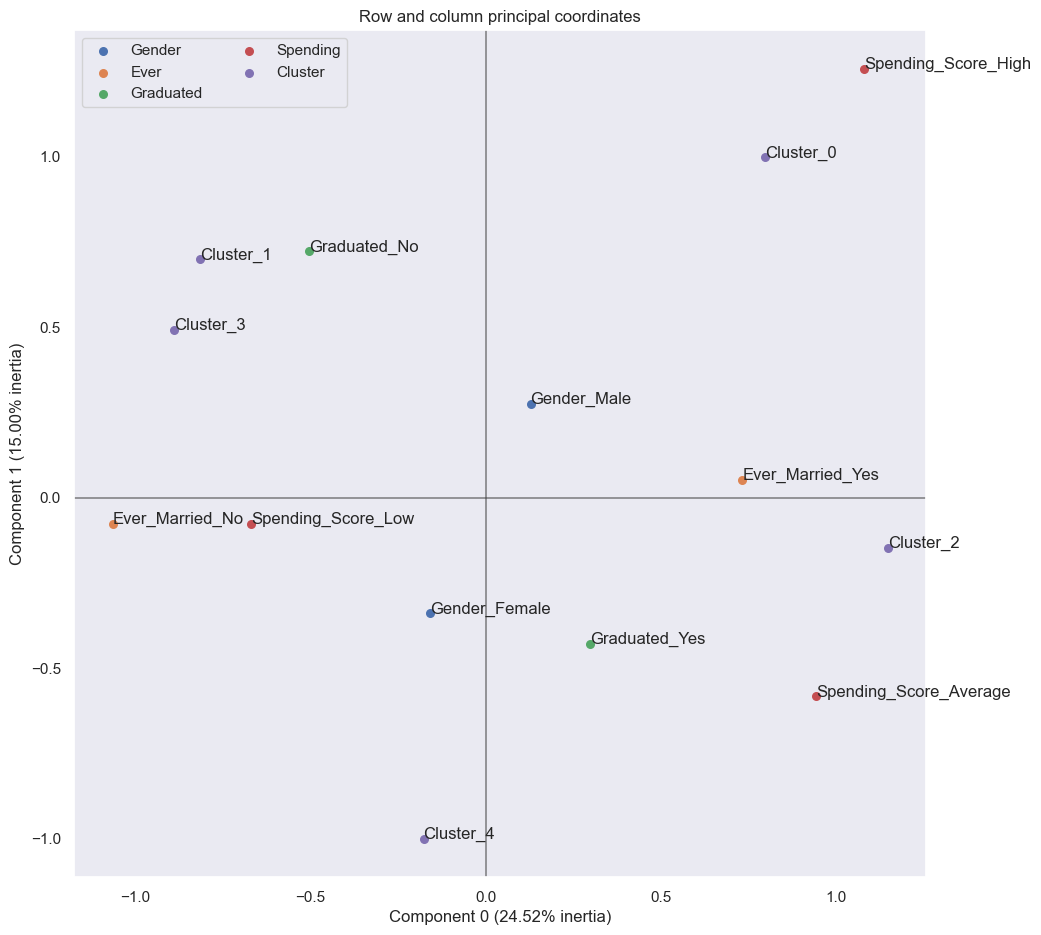

In [240]:
# Plotting Perceptual Map
ax = mca.plot_coordinates(X=df_people,show_row_points=False,
                          row_points_size=10,
                          show_row_labels=False,
                          show_column_points=True,
                          column_points_size=30,
                          figsize=(11,11),
                          show_column_labels=True,
                          legend_n_cols=2)

Observing the perceptual map, some patterns can be observed.

'Spending_Score_Low' is highly associated with 'Ever_Married_No', so if the analysis is about looking for people who would be more likely to spend a lot, this group would not be an interesting target.

On the other hand, the category most associated with 'Spending_Score_High' is 'Cluster_0', which is composed of older people (mean age 70) living with few people (mean 1.8 person).


Clusters 1 and 3, composed of younger people (average 31 and 29 years old) are highly associated with each other and with the 'Graduated_No' group.

'Spending_Score_Average' is most commonly associated with 'Graduated_Yes' and 'Cluster_1', which is defined by people with an average household size of 5.87.